# Machine learning: regression

We'll try to predict missing well logs using regression.

The data are from Colorado. We've already loaded the data into a CSV.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

%matplotlib inline

In [11]:
uri = 'https://www.dropbox.com/s/3vrb35szuvzl93w/Colorado_well_data.csv?dl=1'

In [12]:
df = pd.read_csv(uri, index_col=0)

In [13]:
df.describe()

,Well,Depth,CAL,GR,SP,RES,NPHI,RHOB,DT
count,465864.000000,465864.000000,458315.000000,453415.000000,465476.000000,463761.000000,456505.000000,458052.000000,461165.00000
mean,44.999193,2008.621936,8.190682,115.278626,-28.627539,8.809174,1.741183,2.539519,84.64820
std,27.082953,289.092141,0.571554,36.154381,182.077069,39.220056,7.087623,2.584660,11.23414
min,1.000000,1321.917600,2.980800,3.090000,-848.849399,0.133100,-1.027000,-811.401500,-2.99600
25%,21.000000,1777.898400,7.847100,101.203100,-185.649600,2.687200,0.213200,2.517900,78.33370
50%,45.000000,1984.248000,8.013000,112.795300,4.648150,3.671000,0.264600,2.557100,86.49300
75%,67.000000,2204.466000,8.428800,126.614800,121.489950,6.361700,0.299400,2.587800,92.61960
max,96.000000,2810.560800,14.785900,2160.508497,662.844700,2000.000000,88.737900,3.033000,144.35340


In [14]:
df = df.dropna()

# Visual inspection of the data space

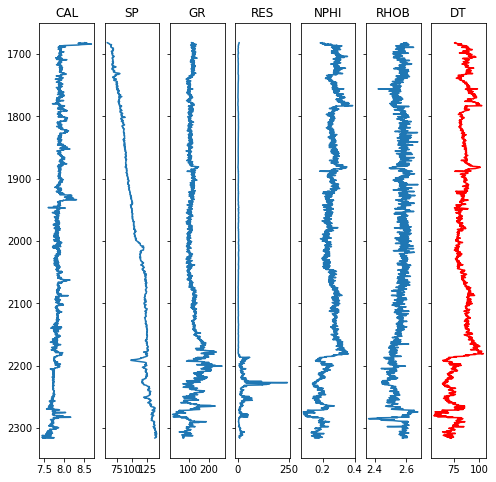

In [24]:
well = 1

features = ['CAL', 'SP', 'GR', 'RES', 'NPHI', 'RHOB']
target = 'DT'

fig, axs = plt.subplots(ncols=len(features)+1, sharey=True, figsize=(8,8))

for ax, feature in zip(axs, features):
    ax.plot(df.loc[df.Well==well, feature], df.loc[df.Well==well, 'Depth'])
    ax.set_title(feature)
axs[-1].plot(df.loc[df.Well==well, target], df.loc[df.Well==well, 'Depth'], color='red')
axs[-1].set_title(target)
axs[-1].invert_yaxis()

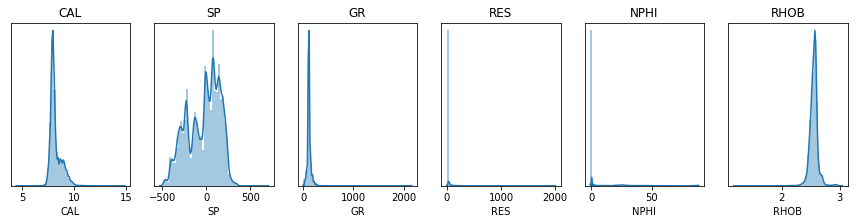

In [25]:
fig, axs = plt.subplots(ncols=len(features), figsize=(15, 3))

for ax, feature in zip(axs, features):
    ax = sns.distplot(df[feature], ax=ax)
    ax.set_title(feature)
    ax.set_yticks([])

Make a 'log<sub>10</sub> resisitivity' to deal with the usual RES distribution:

In [26]:
df['LogRes'] = np.log10(df.RES)
df = df.loc[df.LogRes > 0]

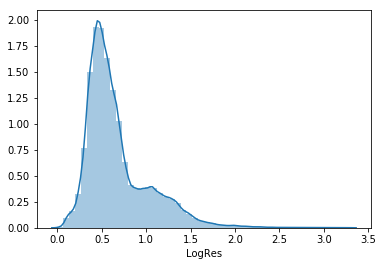

In [27]:
sns.distplot(df.LogRes)

And update the `features` list:

In [28]:
features.remove('RES')
features.append('LogRes')

Now fix the gamma ray:

In [35]:
df.GR = df.GR.clip(upper=600)

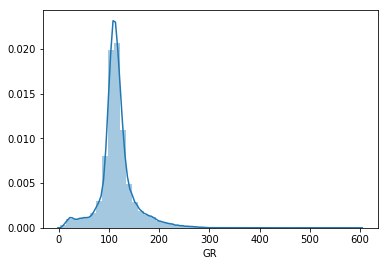

In [36]:
sns.distplot(df.GR)

And the NPHI:

In [37]:
df = df.loc[(0 <= df.NPHI) & (df.NPHI <= 0.5)]

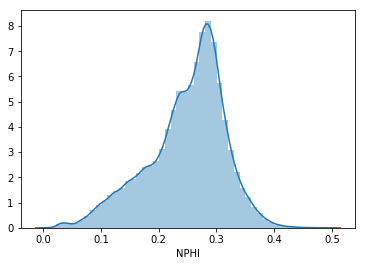

In [38]:
sns.distplot(df.NPHI)

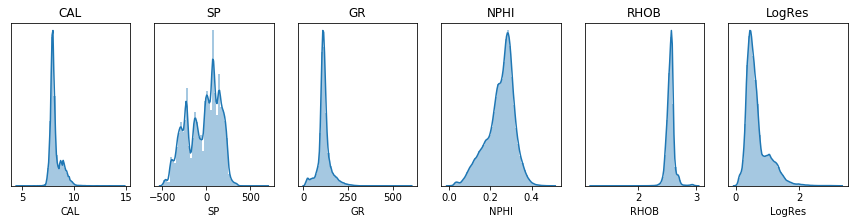

In [39]:
fig, axs = plt.subplots(ncols=len(features), figsize=(15, 3))

for ax, feature in zip(axs, features):
    ax = sns.distplot(df[feature], ax=ax)
    ax.set_title(feature)
    ax.set_yticks([])

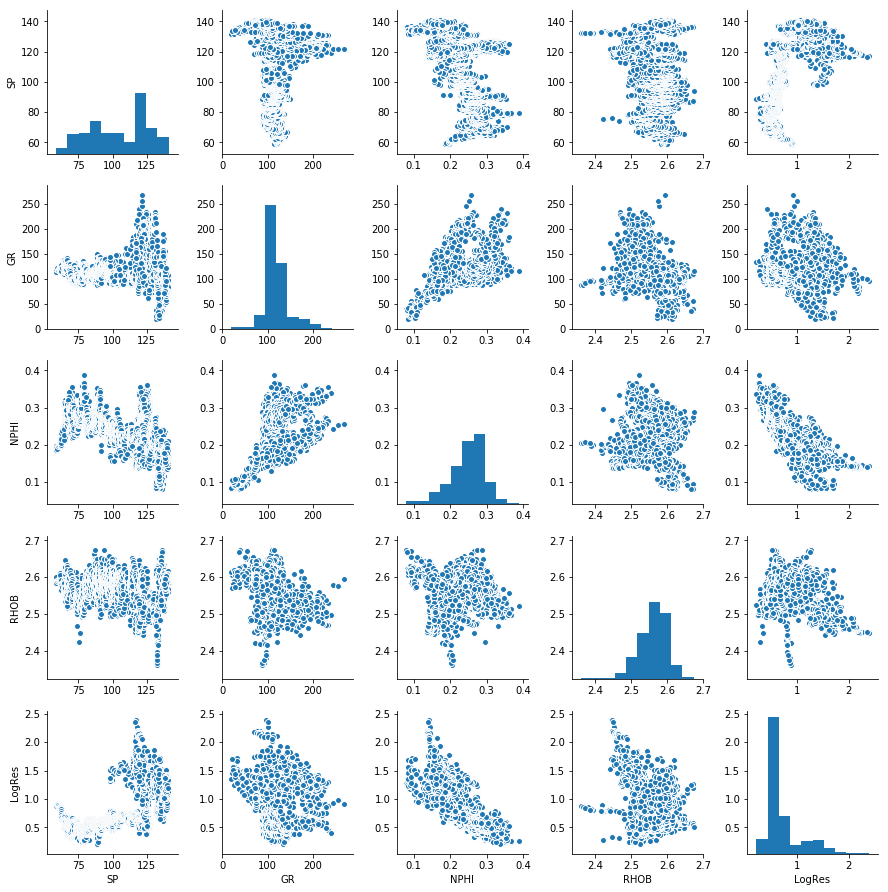

In [40]:
sns.pairplot(df[df.Well == 1.0], vars=features[1:])

# Split the dataset

In [41]:
# How many wells are in the data set
df.Well.unique()

array([  1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  34.,  35.,  36.,  39.,
        40.,  41.,  42.,  43.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  79.,  80.,  81.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  93.,  94.,  95.,  96.])

In [42]:
len(df.Well.unique())

83

 Let's start by training on the first five wells only


In [43]:
n = 5  # We'll come back and change this number.

In [44]:
df_train = df[df.Well <= n].copy()
df_val = df[(df.Well >= 70) & (df.Well < 80)].copy()
df_test = df[(df.Well >= 80) & (df.Well < 90)].copy()
df_app = df[df.Well >= 90].copy()

In [45]:
features = ['GR', 'NPHI', 'RHOB', 'LogRes']
target = 'DT'

In [46]:
X_train = df_train[features].values
y_train = df_train[target].values

X_val = df_val[features].values
y_val = df_val[target].values

X_test = df_test[features].values
y_test = df_test[target].values

## Check the distributions

In [47]:
features

['GR', 'NPHI', 'RHOB', 'LogRes']

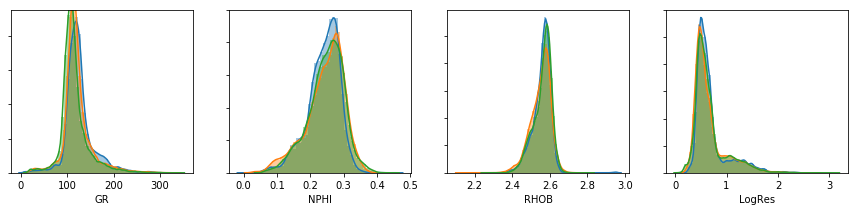

In [48]:
fig, axs = plt.subplots(ncols=len(features), figsize=(15,3))

for ax, feature in zip(axs, features):
    sns.distplot(df_train[feature], ax=ax)
    sns.distplot(df_val[feature], ax=ax)
    sns.distplot(df_test[feature], ax=ax)
    ax.set_yticklabels([])

## Train a model

In [50]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

regr = Ridge()
regr.fit(X_train, y_train)
df_val['DT_pred_LR'] = regr.predict(X_val)

In [51]:
df_val.head()

,Well,Depth,CAL,GR,SP,RES,NPHI,RHOB,DT,LogRes,DT_pred_LR
361088,70.0,1591.6656,7.9294,96.5902,-36.2480,4.2553,0.2360,2.5569,81.7599,0.628930,83.344693
361089,70.0,1591.8180,7.8347,88.0570,-36.2602,4.2799,0.2318,2.5665,81.9724,0.631434,82.337699
361090,70.0,1591.9704,7.7835,90.6360,-36.1782,4.2534,0.2658,2.5581,82.3065,0.628736,85.292010
361091,70.0,1592.1228,7.7725,98.7434,-36.1113,4.2273,0.2623,2.5294,82.4518,0.626063,86.454666
361092,70.0,1592.2752,7.8093,102.5581,-36.1973,4.2279,0.2473,2.5221,82.4496,0.626125,85.761244


In [52]:
def plot_track(df, idx, true, pred):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(12,2)
    true = df.loc[df.Well == idx, true]
    pred = df.loc[df.Well == idx, pred]
    depths = df.loc[df.Well == idx, 'Depth']
    ax.plot(depths, true, 'k', lw=1.5)
    ax.plot(depths, pred, 'r', lw=1.5)
    ax.set_xlim(1300, 2400)
    ax.set_ylim(40, 140)
    return

In [53]:
@interact(idx=(df_val.Well.unique().min(), df_val.Well.unique().max(), 1))
def plot_different_wells(idx):
    plot_track(df_val, idx, 'DT', 'DT_pred_LR')
    return


A Jupyter Widget

# Evaluation metrics

In [54]:
from sklearn.metrics import r2_score, mean_squared_error

r2_score(df_val.DT, df_val.DT_pred_LR)

0.83519657171388595

And the RMS error:

In [55]:
np.sqrt(mean_squared_error(df_val.DT, df_val.DT_pred_LR))

3.6067822747874465

## Check error distribution

In particular, we want to check that:

1. The errors are normally distributed with a zero mean.
1. The variance of the errors is not correlated with the parameters.

There's some good advice about normality tests in [this article by Jason Brownlee](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/).

First we'll just use visual inspection:

In [56]:
residuals = df_val['DT_pred_LR'] - df_val['DT']

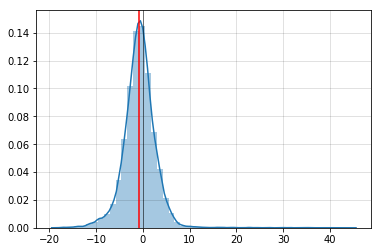

In [57]:
sns.distplot(residuals)
plt.axvline(0, color='k', lw=0.5)
plt.axvline(residuals.mean(), color='r')
plt.grid(color='k', alpha=0.15)
plt.show()

#### Normality: QQ plot

A quantile-quantile plot generates an idealized distribution, in this case a Gaussian. The idealized samples are divided into quantiles, then each data point in the sample is paired with a similar member from the idealized distribution. The line `'s'` represents the standard 'normal' distribution.

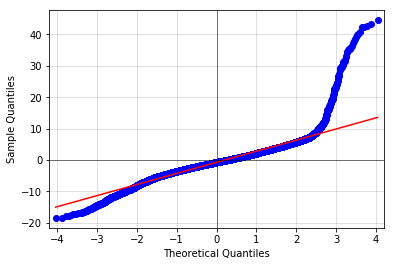

In [58]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='s')
plt.axvline(0, color='k', lw=0.5)
plt.axhline(0, color='k', lw=0.5)
plt.grid(color='k', alpha=0.15)
plt.show()

#### Normality: Shapiro&ndash;Wilk test

Not convinced about this &mdash; seems like most large samples don't fit. `p` just gets very small.

In [59]:
from scipy.stats import shapiro

res_shuf = residuals.values
np.random.shuffle(res_shuf)

stat, p = shapiro(res_shuf[:500])
print(f'Statistics = {stat:.3f}, p = {p:.3f}')

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics = 0.957, p = 0.000
Sample does not look Gaussian (reject H0)


#### Homoscedasticity: visual inspection

We want to check that the variance of the errors is not correlated with our parameters.

If they are correlated (if the plots below show points with narrow spread at one end and wide at the other), then there are nonlinearities in the data that are not captured by the model. It could be that outliers are skewing the distribution.

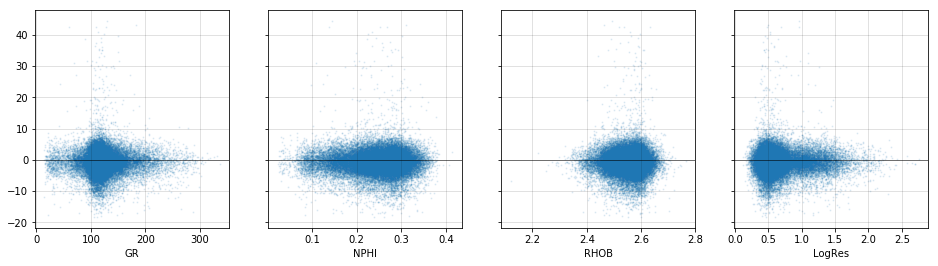

In [60]:
fig, axs = plt.subplots(ncols=len(features), figsize=(16,4), sharey=True)

for ax, feature in zip(axs, features):
    ax.scatter(df_val[feature], residuals, s=1, alpha=0.1)
    ax.set_xlabel(feature)
    ax.axhline(0, color='k', lw=0.5)
    ax.grid(color='k', alpha=0.15)

Seems like there could be an issue in shales (low NPHI), and in rocks with low HC saturation.

## Coefficients

In [61]:
np.set_printoptions(suppress=True)
regr.coef_

array([  0.0346156 ,  73.73092273, -38.53180916, -12.79713642])

In [62]:
regr.intercept_

169.17115557559816

We can makea list of the features that contributed most:

In [63]:
list(reversed(np.array(features)[np.argsort(np.abs(regr.coef_))]))

['NPHI', 'RHOB', 'LogRes', 'GR']

In [69]:
features

['GR', 'NPHI', 'RHOB', 'LogRes']

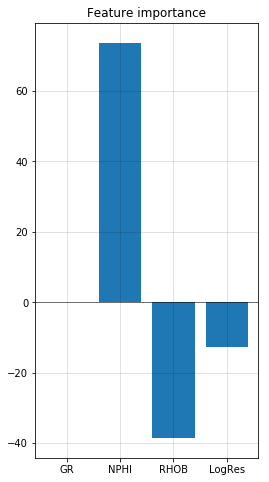

In [78]:
fig, ax = plt.subplots(figsize=(4,8))

idx = np.arange(len(features))
ax.bar(idx, regr.coef_, align='center')
ax.axhline(0, color='k', lw=0.5)
ax.set_xticks(idx)
ax.set_xticklabels(features)
ax.grid(color='k', alpha=0.15)

plt.title('Feature importance')
plt.show()

<html><hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div></html>